In [4]:
%pip install ipympl

import sys
import os
import yaml


sys.path.insert(1, "/Volumes/EeroQ/lib/zeroheliumkit-dev/") 
import numpy as np
from math import pi

from shapely import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon
from shapely import affinity, intersects, line_merge, box, intersection
import shapely.affinity as aff
import copy

import matplotlib
from zeroheliumkit import GeomCollection, SpiralInductor
from zeroheliumkit.src.settings import *
from zeroheliumkit.src.importing import Reader_DXF, Reader_GDS, Reader_Pickle


%matplotlib widget
%config InlineBackend.figure_format='retina'

from zeroheliumkit import Structure, Entity, Anchor, SuperStructure, GeomCollection, Taper, MultiAnchor, ArbitraryLine, Skeletone
from zeroheliumkit import Rectangle, Meander, MeanderHalf, Square, StraightLine, Circle, ArcLine
from zeroheliumkit.src.utils import midpoint, round_polygon
from zeroheliumkit.src.settings import *
from zeroheliumkit.src.importing import Reader_Pickle
from zeroheliumkit.helpers.resonator_calc import CPW_params
from zeroheliumkit.helpers.constants import speedoflight, mu_0, epsilon_0, hbar, alpha
import importlib
import tabulate

# sys.path.append('C:\\Users\\gageg\\source\\repos\\zeroheliumkit')



  

Note: you may need to restart the kernel to use updated packages.


In [5]:
with open('..\examples\params.yaml', 'r') as file:
    params = yaml.safe_load(file)


def calculate_sheet_inductance(
    width: float,
    length: float,
    thickness: float,
    resistivity: float,
    critical_temp: float,
    delta_0: float = 1.76,  # BCS gap parameter
) -> tuple[float, float]:
    """
    Calculate sheet inductance from 4-point probe measurements
    
    Args:
        width: Width of conductor (m)
        length: Length between voltage probes (m) 
        thickness: Film thickness (m)
        resistance: Measured resistance at T ≈ Tc (Ω)
        critical_temp: Critical temperature (K)
        delta_0: Superconducting gap parameter (default 1.76 for BCS)
    
    Returns:
        tuple[float, float]: (Sheet resistance (Ω/□), Kinetic inductance (H/□))
    """
    # Calculate sheet resistance 
    R_square = resistivity  / thickness
    print("R_square: ", R_square) 
    # Calculate kinetic inductance using BCS relationship
    h_bar = 1.0545718e-34  # Reduced Planck constant
    delta = delta_0 * critical_temp * 1.380649e-23  # Gap energy in Joules
    
    L_kinetic = h_bar * R_square / (pi * delta)
    
    return R_square, L_kinetic




GHz = 1e9
MHz = 1e6
kHz = 1e3

cm = 1e-2
mm = 1e-3
um = 1e-6
nm = 1e-9

R_sq, L_k = calculate_sheet_inductance(
    width=10*um,
    length=1000*um, 
    thickness=10*nm,
    resistivity= 5.5*um,  # Example values
    critical_temp=10.84,
    # measurement_temp=9.2
)
print("L_k: ", L_k)

cpw = CPW_params(
    eps_substrate=params["resonator"]["eps"],
    width=params["resonator"]["geometry"]["w"] * um,
    gap=params["resonator"]["geometry"]["g"] * um, 
    height_substrate=params["resonator"]["substrate_h"] * um,
    sheet_inductance=L_k
)

cpw.calculate_params()

R_square:  550.0
L_k:  7.00912391380422e-11


-------  ----------  ---------  -------  ---  -------  --------------  ---------  -------
f0, GHz  length, mm  width, um  gap, um  eps  eps_eff  impedance, Ohm  L, nH/m    C, pF/m
7.7      0.41        1.8        1.0      11   6.0      494.2           39353.877  161.133
-------  ----------  ---------  -------  ---  -------  --------------  ---------  -------
Impedance:  494.197857800328
-------  ----------  ---------  -------  ---  -------  --------------  ---------  -------
f0, GHz  length, mm  width, um  gap, um  eps  eps_eff  impedance, Ohm  L, nH/m    C, pF/m
7.7      0.41        1.8        1.0      11   6.0      494.2           39353.877  161.133
-------  ----------  ---------  -------  ---  -------  --------------  ---------  -------
Total length required: 3973.69 µm
Straight sections: 1400 µm
Bend length: 687.73 µm
Remaining length for meanders: 1885.96 µm
Length per meander: 269.42 µm
params 1
Cap height:  2
Cap width:  3.6
p14
p1
gnd
Geometries saved successfully.


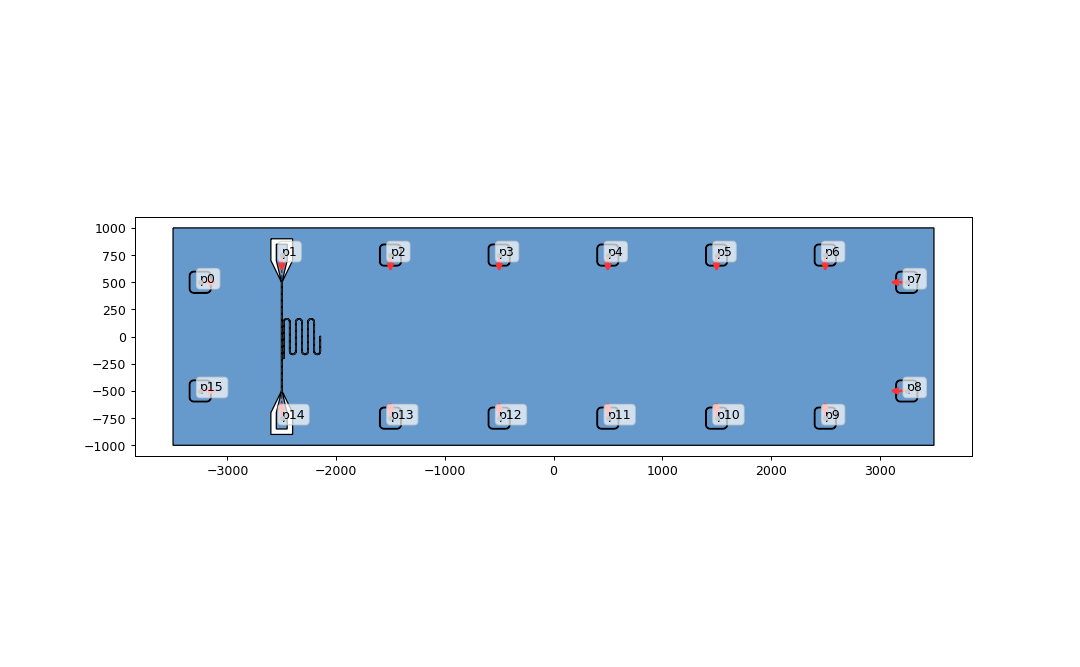

In [9]:
target_freq = params["resonator"]["frequency"] * GHz

cpw.resonator_length(
    resonator_frequency=target_freq,
    resonator_type=params["resonator"]["type"],
    harmonic=0)

plot_config = {"gnd": BLUE,
               "open": ORANGE,
               "temp": RED,
               "island": YELLOW2,
               "anchors": GRAY,
               "other": GREEN
               }
route_config =  {}


pad = Structure()

pad.add_layer("open", round_polygon(Square(200), 40))
pad.add_layer("temp", round_polygon(Square(190), 36))
# pad.add_layer("open", 
pad.add_anchor(Anchor((0,0), -90, "o"))


cpwlauncher = Taper(length = 200,
                    layers = {"temp": (100, 3.6),
                              "open": (200, 4)},
                              alabel=("a1","a2"))
# cpwlauncher.cut_polygon("open", Rectangle(100, 200, (-325,0)))
cpwlauncher.cut_polygon("temp", Rectangle(50, 400, (-300+25,0)))
cpwlauncher.get_anchor("a1").move(150)
cpwlauncher.remove_skeletone()


# cpwlauncher.quickplot(plot_config)

chip = SuperStructure(route_config)

Lx = 7000
Ly = 2000
spacing = 1000
offset = 250

# chip.add_layer("gnd", Rectangle(Lx, Ly))

coords_t = [(-Lx/2 + offset,spacing/2, 0)] + [(-spacing*5/2 + spacing*i, Ly/2 - offset, -90) for i in range(6)] + [(Lx/2 - offset,spacing/2, 180)]
coords_d = [(Lx/2 - offset,-spacing/2, 180)] + [(spacing*5/2 - spacing*i, -Ly/2 + offset, 90) for i in range(6)] + [(-Lx/2 + offset,-spacing/2, 0)]



for i, coord in enumerate(coords_t + coords_d):
    x, y, angle = coord
    chip.add_anchor(Anchor((x,y), angle, "p"+str(i)))



# for anc in chip.anchors.labels:
#     chip.append(pad, anchoring=(anc, "o"), direction_snap=True, remove_anchor="o")
    # chip.remove_anchor(anc)
# chip.add_anchor(Anchor((-3500,-1000), 0, "bottom_left_corner"))
# chip.add_anchor(Anchor((3500,1000), 0, "top_right_corner"))
# chip.add_anchor(Anchor((-3500,1000), 0, "top_left_corner"))
# chip.add_anchor(Anchor((0,0), 0, "chip_center"))


def construct_trans_skeletone(params: dict, start: str, stop: str) -> LineString:
    g_params = params["resonator"]["geometry"]
    d_a = g_params['coupling_length']        
    d_w = g_params['distance_from_waveguide'] 
    d_l = g_params['openend_length']            
    d_R = g_params["radius"]          
    n = g_params['num']                      
    w = g_params["w"]                        
    g = g_params["g"]      
                       
    
    transline = CPW_params(
        eps_substrate=params["resonator"]["eps"],
        width=w * um,
        gap=g * um,
        height_substrate=params["resonator"]["substrate_h"] * um,
        sheet_inductance=L_k
    )
    transline.calculate_params()
    print("Impedance: ", transline.Z)
    transline.resonator_length(params["resonator"]["frequency"] * GHz, params["resonator"]["type"], 0)
    length = transline.length/um
    

    sk = Entity()
    sk.add_line(LineString([chip.get_anchor(start).point, chip.get_anchor(stop).point]))
    
    return sk.skeletone

def construct_res_skeletone(params: dict, start, stop, cpw_params: CPW_params) -> tuple[LineString, Anchor]:
    g_params = params["resonator"]["geometry"]
    d_a = g_params['coupling_length']        
    d_w = g_params['distance_from_waveguide']
    d_l = g_params['openend_length']                     
    n = g_params['num']                      
    w = g_params["w"]                        
    g = g_params["g"]   

    d_R = 10*(g+w)

    # Add debug prints
    print(f"Total length required: {cpw_params.length/um:.2f} µm")
    print(f"Straight sections: {d_a + d_w + d_l} µm")
    print(f"Bend length: {d_R * (3 * pi/2 + 2 * pi * n + 1):.2f} µm")
    
    # Calculate meandering section length
    straight_sections = d_a + d_w + d_l
    bend_length = d_R * (3 * pi/2 + 2 * pi * n + 1)
    meander_length = cpw_params.length/um - straight_sections - bend_length
    
    print(f"Remaining length for meanders: {meander_length:.2f} µm")
    print(f"Length per meander: {meander_length/(2 * n + 1):.2f} µm")
    
    # Calculate individual meander segment length
    d_b = meander_length/(2 * n + 1)
    
    if d_b < 0:
        raise Exception("Calculated length too short for current geometry. Reduce number of meanders or increase coupling lengths.")

    sk = Entity()
    temp_anch = Anchor(start, -90, "res_start")
    
    sk.add_line(LineString([start, stop]))
    
    # Add meanders with calculated segment length
    for _ in range(n):
        sk.add_line(Meander(d_b, d_R, direction=-180), ignore_crossing=True)
    
    return sk.skeletone, temp_anch



# Calculate resonator length for target frequency
target_freq = 7.7 * GHz

# Calculate resonator length for target frequency
target_freq = 7.7 * GHz
resonator_type = params["resonator"]["type"]
harmonic = 0

# Calculate length using direct formula
if resonator_type == 0.25:
    length_factor = 0.25 * (2*harmonic + 1)
elif resonator_type == 0.5:
    length_factor = 0.5 * (harmonic + 1)
else:
    raise Exception("Choose 1/4 or 1/2 resonator type")
    
# Calculate length using phase velocity
cpw.length = length_factor * speedoflight / (target_freq * np.sqrt(cpw.eps_eff))
cpw.frequency = target_freq

# Print parameters for debugging
parameters = {
    "f0, GHz": round(target_freq/GHz, 3),
    "length, mm": round(cpw.length/mm, 2),
    "width, um": round(cpw.width/um, 2),
    "gap, um": round(cpw.gap/um, 2),
    "eps ": round(cpw.eps_substrate),
    "eps_eff": round(cpw.eps_eff, 2),
    "impedance, Ohm": round(cpw.Z, 2),
    "L, nH/m": round(cpw.L * 1e9, 3),
    "C, pF/m": round(cpw.C* 1e12, 3)
}


# Create resonator with calculated length

trans_sk = construct_trans_skeletone(params, "p1", "p14")
res_sk, temp_anch = construct_res_skeletone(
    params, 
    (0, params["resonator"]["geometry"]["coupling_length"]), 
    (0, 0),
    cpw
)

chip.add_line(trans_sk.lines)

resonator = Structure()
resonator.add_anchor(temp_anch)
resonator.add_line(res_sk.lines)

# resonator.quickplot(plot_config)

x = chip.get_anchor("p1").point.x+10*parameters["width, um"]
ytop = chip.get_anchor("p1").point.y
ybottom = chip.get_anchor("p14").point.y
middle = (x,(ytop+ybottom)/2 - params["resonator"]["geometry"]["coupling_length"])


chip.add_anchor(Anchor((middle),90,"res_loc"))



chip.append(resonator,anchoring=["res_loc","res_start"],direction_snap=True, remove_anchor="res_start")
chip.buffer_line("open", parameters["width, um"] + parameters["gap, um"], cap_style="square", join_style="mitre")
chip.buffer_line("temp", parameters["width, um"], cap_style="flat", join_style="mitre")


# Resonator with more vertical space

chip.buffer_line("island", parameters["width, um"], cap_style="square", join_style="mitre")
chip.buffer_line("temp", parameters["width, um"], cap_style="flat", join_style="mitre")




cap_height = 2*params["resonator"]["geometry"]["g"]
cap_width = parameters["width, um"] + 1.8*params["resonator"]["geometry"]["g"]

print("params", params["resonator"]["geometry"]["g"])
print("Cap height: ", cap_height)
print("Cap width: ", cap_width)


middle_offset = (middle[0],middle[1]-cap_height)

chip.add_layer("temp",Rectangle(cap_width,cap_height, middle_offset))
# Process layers

chip.cut_polygon("open",chip.temp)



chip.cut_polygon("open", chip.island)
chip.cut_polygon("temp", chip.island)

chip.remove_layer("island")


# Add pads
chip.remove_anchor("res_loc")
for anc in chip.anchors.labels:
        if anc == "p1" or anc == "p14":
                print(anc)
                chip.append(cpwlauncher, anchoring=(anc, "a1"), direction_snap=True, remove_anchor="a1")
                chip.remove_anchor("a2")
        else:
                chip.append(pad, anchoring=(anc, "o"), direction_snap=True, remove_anchor="o")


chip.cut_polygon("open",chip.temp)

chip.remove_layer("island")
chip.remove_layer("temp")

chip.add_layer("gnd", Rectangle(Lx, Ly))
chip.cut_polygon("gnd", chip.open)

chip.remove_layer("open")


for layer in chip.layers:
      print(layer)
      
chip.quickplot(plot_config)

layer_cfg = {"gnd": {"layer": 1, "datatype": 0}}

chip.export_gds("chipShortClose",layer_cfg)